# Welter



# Welter issue #7
## Going order-by-order
### Part 1- Plot each order on the same plot

Michael Gully-Santiago  
Tuesday, December 29, 2015  

Now that we have all the estimates for the stellar and calibration parameters, we can correct the spectrum and visually compare the data to the model.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

In [3]:
import pandas as pd

In [4]:
sns.set_context('paper', font_scale=1.6)
sns.set_style('ticks')

In [5]:
sf_dat = pd.read_csv('../data/analysis/IGRINS_LkCa4_run01_last20kMCMC.csv')

In [6]:
sf_dat.head()

wl_start  wl_end band  number  tell_trans  m_val  wl_center     Teff_05p  \
0     18092   18346    H       0    0.117487     98    18219.0          NaN   
1     17914   18165    H       1    0.342583     99    18039.5  3501.068994   
2     17739   17988    H       2    0.666035    100    17863.5  3503.000806   
3     17568   17815    H       3    0.827089    101    17691.5  3500.818140   
4     17400   17645    H       4    0.904758    102    17522.5  3501.463135   

      Teff_50p     Teff_95p    ...        c3_95p    SA_05p    SA_50p  \
0          NaN          NaN    ...           NaN       NaN       NaN   
1  3513.371826  3552.386816    ...      0.033320  4.966462  5.342383   
2  3533.342041  3598.625757    ...      0.009295  0.561469  0.616338   
3  3510.430420  3543.398657    ...      0.021796  0.413524  0.454453   
4  3521.662598  3629.461426    ...      0.009541  0.263719  0.294708   

     SA_95p    LA_05p    LA_50p    LA_95p     ll_05p     ll_50p     ll_95p  
0       NaN       NaN       NaN       NaN        NaN        NaN        NaN  
1  5.683854 -1.801218 -1.722525 -1.645387  21.389151  27.485828  33.448536  
2  0.674881 -1.874350 -1.831479 -1.785062  14.759428  16.864183  19.478700  
3  0.498684 -1.868368 -1.826906 -1.777924  16.175522  18.257780  21.050026  
4  0.326677 -1.862501 -1.813840 -1.750587  17.752643  20.574348  23.989191  

[5 rows x 43 columns]

# Plot of "flux calibrated" spectrum!

In [7]:
import h5py
import numpy as np
from numpy.polynomial import Chebyshev as Ch

In [8]:
import yaml

In [9]:
import json

In [10]:
gi = sf_dat.Teff_50p == sf_dat.Teff_50p
ms = sf_dat.m_val[gi]

In [11]:
sf_out = '../sf/m{:03d}/config.yaml'.format(101)

f = open(sf_out)
config = yaml.load(f)
f.close()

In [12]:
config

{'Comments': 'LkCa4 single order: m = 101, autogenerated config file.',
 'PCA': {'path': '/Users/gully/GitHub/welter/sf/m101/PHOENIX_IGRINS_H_PCA.hdf5',
  'priors': [[2.0, 0.0075], [2.0, 0.75], [2.0, 0.75]],
  'threshold': 0.999},
 'Phi': {'l': 20.0, 'logAmp': -2.0, 'sigAmp': 1.0},
 'Phi_jump': {'l': 0.25, 'logAmp': 0.01, 'sigAmp': 0.025},
 'Theta': {'Av': 0.0,
  'grid': [3510, 3.7, 0.0],
  'logOmega': -0.31759775866703227,
  'vsini': 28.5,
  'vz': 94.7},
 'Theta_jump': {'Av': 0.01,
  'grid': [3, 0.003, 0.001],
  'logOmega': 0.0003,
  'vsini': 0.05,
  'vz': 0.05},
 'cheb_degree': 4,
 'cheb_jump': 0.0001,
 'data': {'files': ['/Users/gully/GitHub/welter/data/reduced/LkCa4_IGRINS_m101.hdf5'],
  'grid_name': 'PHOENIX',
  'instruments': ['IGRINS_K'],
  'orders': [0]},
 'grid': {'buffer': 30.0,
  'hdf5_path': '/Users/gully/GitHub/welter/sf/m113/libraries/PHOENIX_IGRINS_m101.hdf5',
  'key_name': 't{0:.0f}g{1:.1f}z{2:.1f}',
  'parname': ['temp', 'logg', 'Z'],
  'parrange': [[3500, 4300], [3.5,

In [13]:
import os

In [14]:
cwd = os.getcwd()

# see note below!

Let's separate out the generating the model part from the plotting part.

## Edit all the config.yaml files with desired stellar model parameters

In [15]:
for m in ms:
    index = sf_dat.index[sf_dat.m_val == m]
    mdir = 'm{:03d}'.format(m)
    f = h5py.File('../data/reduced/LkCa4_IGRINS_{}.hdf5'.format(mdir), 'r')
    log_Omega = sf_dat.get_value(index.values[0], 'logO_50p')
    
    len_wl = len(f['wls'])
    xs = np.arange(len_wl)
    
    wls = f['wls'][:]
    f.close()
    
    sf_out = '../sf/m{:03d}/config.yaml'.format(m)

    f2 = open(sf_out)
    config = yaml.load(f2)
    f2.close()

    config['data']['files'] = ['/Users/gully/GitHub/welter/data/reduced/LkCa4_IGRINS_m{:03d}.hdf5'.format(m)]
    config['grid']['hdf5_path'] = '/Users/gully/GitHub/welter/sf/m113/libraries/PHOENIX_IGRINS_m{:03d}.hdf5'.format(m)
    lb, ub = int(np.floor(wls[0])), int(np.ceil(wls[-1]))

    config['grid']['wl_range'] = [lb, ub]
    config['PCA']['path'] = '/Users/gully/GitHub/welter/sf/m{:03d}/PHOENIX_IGRINS_H_PCA.hdf5'.format(m)
    config['name'] = 'LkCa4_m{:03d}'.format(m)
    config['Comments'] = 'LkCa4 single order: m = {}, autogenerated config file.'.format(m)
    config['data']['instruments'] =['IGRINS_K']
    config['Theta']['grid'] = [int(sf_dat.Teff_50p[index.values[0]]), 3.7, 0.0]
    config['Theta']['vsini'] = float(np.round(sf_dat.vi_50p[index.values[0]], decimals=1))
    config['Theta']['vz'] = float(np.round(sf_dat.vz_50p[index.values[0]], decimals=1))

    print("{:03d}: {:.0f}  -  {:.0f}   {}".format(m, wls[0], wls[-1], mdir))

    #os.makedirs(path_out, exist_ok=True)
    with open(sf_out, mode='w') as outfile:
        outfile.write(yaml.dump(config))

099: 17975  -  18155   m099
100: 17800  -  17978   m100
101: 17628  -  17805   m101
102: 17460  -  17635   m102
103: 17295  -  17468   m103
104: 17133  -  17305   m104
105: 16975  -  17145   m105
106: 16819  -  16988   m106
107: 16667  -  16834   m107
108: 16517  -  16682   m108
109: 16370  -  16534   m109
110: 16226  -  16388   m110
111: 16084  -  16245   m111
115: 15543  -  15699   m115
116: 15414  -  15568   m116
117: 15287  -  15439   m117
076: 23308  -  23539   m076
077: 23010  -  23238   m077
078: 22719  -  22945   m078
079: 22436  -  22659   m079
080: 22160  -  22380   m080
081: 21891  -  22109   m081
082: 21629  -  21844   m082
083: 21373  -  21585   m083
084: 21123  -  21333   m084
085: 20879  -  21086   m085
086: 20641  -  20846   m086
087: 20408  -  20611   m087
088: 20181  -  20381   m088
089: 19958  -  20157   m089
090: 19741  -  19937   m090
091: 19529  -  19723   m091


## Edit the phi.json file with the default or measured calibration parameters

In [16]:
for m in ms:
    index = sf_dat.index[sf_dat.m_val == m]
    mdir = 'm{:03d}'.format(m)
    
    phi_out = '../sf/m{:03d}/s0_o0phi.json'.format(m)

    jf = open(phi_out)
    phi = json.load(jf)
    jf.close()

    ii = index.values[0]
    
    c1, c2, c3 = sf_dat.c1_50p[ii], sf_dat.c2_50p[ii], sf_dat.c3_50p[ii]
    if c1 != c1:
        phi['cheb'] = [0.0,0,0]
        phi['logAmp']= 0.4
        phi['sigAmp']= -1.9
        phi['l']= 20.0
    if c1 == c1:
        phi['cheb'] = [c1, c2, c3]
        phi['logAmp']= sf_dat.LA_50p[ii]
        phi['sigAmp']= sf_dat.SA_50p[ii]
        phi['l']= sf_dat.ll_50p[ii]
    
    phi['fix_c0'] = True
    
    with open(phi_out, mode='w') as outfile:
        json.dump(phi, outfile, indent=2)

## Generate the model

Check to see if the right files exist.

In [17]:
for m in ms:
    index = sf_dat.index[sf_dat.m_val == m]
    mdir = 'm{:03d}'.format(m)    
    m_path = '/Users/gully/GitHub/welter/sf/{}/'.format(mdir)
    phi_out = '../sf/m{:03d}/s0_o0phi.json'.format(m)
    sf_out = '../sf/m{:03d}/config.yaml'.format(m)

    if os.path.exists(phi_out) & os.path.exists(sf_out):
        print('Both exist for {}'.format(mdir))
    else:
        print('At least one is missing for {}'.format(mdir))
    
    #os.chdir(m_path)
    #os.system('star.py --generate')
    #os.chdir('/Users/gully/GitHub/welter/notebooks')

Both exist for m099
Both exist for m100
Both exist for m101
Both exist for m102
Both exist for m103
Both exist for m104
Both exist for m105
Both exist for m106
Both exist for m107
Both exist for m108
Both exist for m109
Both exist for m110
Both exist for m111
Both exist for m115
Both exist for m116
Both exist for m117
Both exist for m076
Both exist for m077
Both exist for m078
Both exist for m079
Both exist for m080
Both exist for m081
Both exist for m082
Both exist for m083
Both exist for m084
Both exist for m085
Both exist for m086
Both exist for m087
Both exist for m088
Both exist for m089
Both exist for m090
Both exist for m091


## Make a plot: Data

(0, 2)

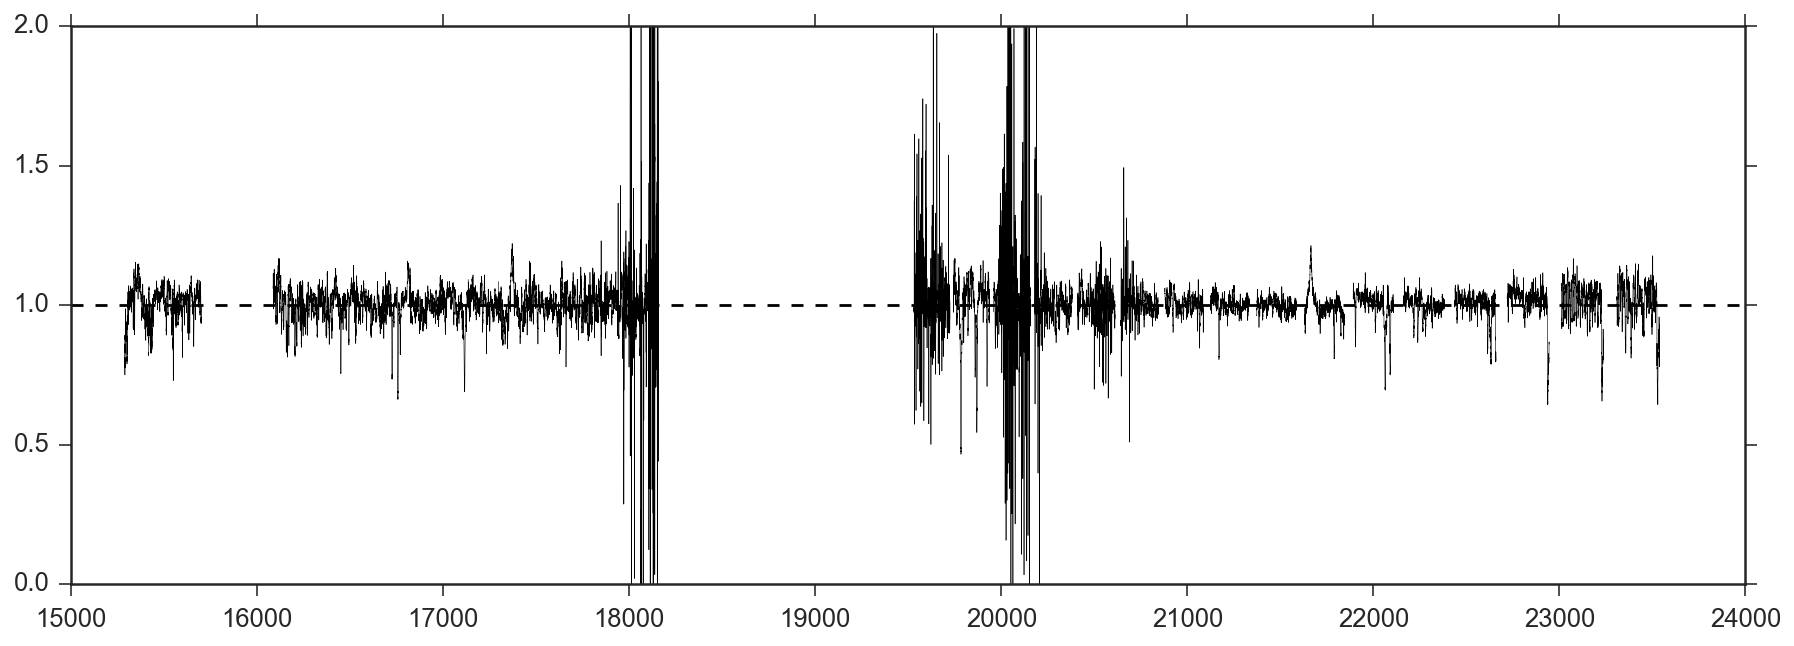

In [18]:
fig = plt.figure(figsize=(15, 5))
for m in ms:
    index = sf_dat.index[sf_dat.m_val == m]
    mdir = 'm{:03d}'.format(m)
    f = h5py.File('../data/reduced/LkCa4_IGRINS_{}.hdf5'.format(mdir), 'r')
    log_Omega = sf_dat.get_value(index.values[0], 'logO_50p')
    #plt.plot(f['wls'], f['fls'], 'r.', alpha=0.05)
    #plt.plot(f['wls'], f['fls']/(10**log_Omega), 'k.', alpha=0.05)
    
    len_wl = len(f['wls'])
    xs = np.arange(len_wl)
    coeff = [1]
    T = []
    for i in range(1, 4):
        # print("i = ", i)
        coeff = [0] + coeff
        Chtemp = Ch(coeff, domain=[0, len_wl - 1])
        Ttemp = Chtemp(xs)
        T += [Ttemp]

    T = np.array(T)

    cns = [sf_dat.c1_50p[index.values[0]], 
          sf_dat.c2_50p[index.values[0]],
          sf_dat.c3_50p[index.values[0]]]

    Tc = np.dot(T.T, cns)

    k = 1.0+ Tc

    plt.step(f['wls'], f['fls']/(10**log_Omega)/k, 'k', linewidth=0.3, alpha=1)

plt.plot([15000, 24000], [1.0, 1.0], 'k--')    
plt.ylim(0, 2)
#plt.xlim(21000, 22000)
#plt.xlim(16300, 17300)

## Make a plot: Models

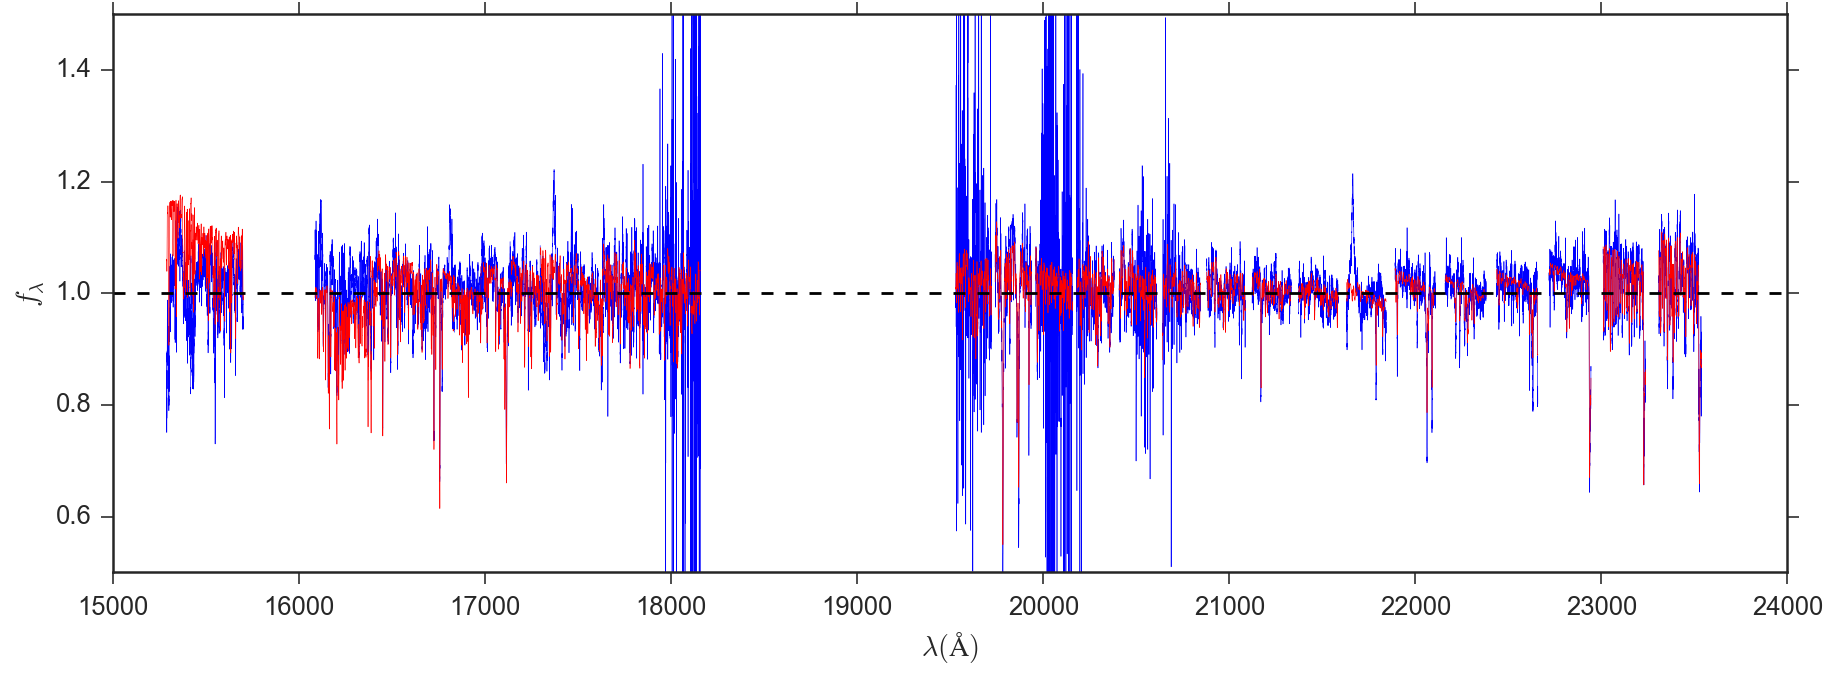

In [19]:
fig = plt.figure(figsize=(15, 5))
for m in ms:
    index = sf_dat.index[sf_dat.m_val == m]
    mdir = 'm{:03d}'.format(m)

    spec_file = open('../sf/{}/s0_o0spec.json'.format(mdir), 'r')
    spec = json.load(spec_file)
    
    f = h5py.File('../data/reduced/LkCa4_IGRINS_{}.hdf5'.format(mdir), 'r')
    log_Omega = sf_dat.get_value(index.values[0], 'logO_50p')
    #plt.plot(f['wls'], f['fls'], 'r.', alpha=0.05)
    #plt.plot(f['wls'], f['fls']/(10**log_Omega), 'k.', alpha=0.05)
    
    len_wl = len(f['wls'])
    xs = np.arange(len_wl)
    coeff = [1]
    T = []
    for i in range(1, 4):
        # print("i = ", i)
        coeff = [0] + coeff
        Chtemp = Ch(coeff, domain=[0, len_wl - 1])
        Ttemp = Chtemp(xs)
        T += [Ttemp]

    T = np.array(T)

    cns = [sf_dat.c1_50p[index.values[0]], 
          sf_dat.c2_50p[index.values[0]],
          sf_dat.c3_50p[index.values[0]]]

    Tc = np.dot(T.T, cns)

    k = 1.0+ Tc

    plt.step(f['wls'], f['fls']/(10**log_Omega)/k, 'b', linewidth=0.3, alpha=1)
    #plt.step(spec['wl'], spec['data']/(10**log_Omega)/k, 'k', linewidth=0.3, alpha=1)
    plt.step(spec['wl'], spec['model']/(10**log_Omega)/k, 'r', linewidth=0.3, alpha=1)
    spec_file.close()

plt.plot([15000, 24000], [1.0, 1.0], 'k--')    
plt.ylim(0.5, 1.5)
plt.xlabel('$\lambda (\AA)$')
plt.ylabel('$f_\lambda$')
#plt.xlim(21000, 22000)
#plt.xlim(16300, 17300)
#plt.xlim(16200, 17800)

## Bokeh version of the above plot

In [20]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, vplot


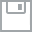
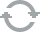
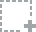
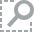
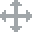
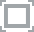
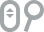
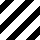
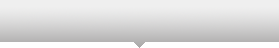
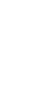
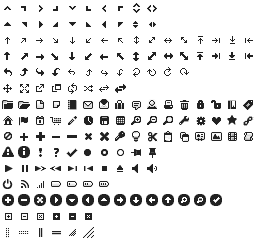
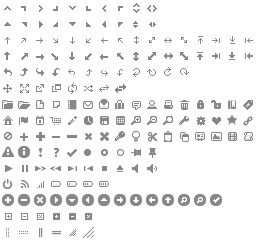
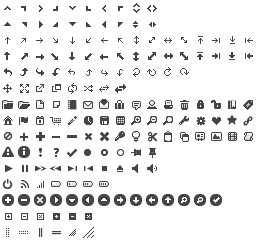
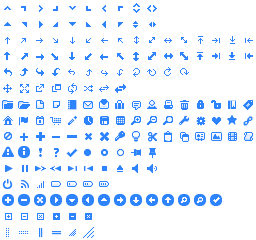
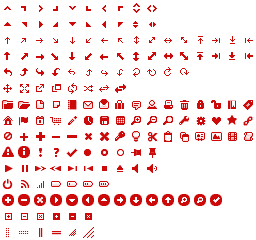
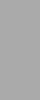
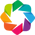
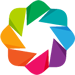

In [21]:
output_notebook()

In [22]:
import bokeh

In [25]:
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

In [26]:
r = figure(tools=TOOLS, plot_width=1000, plot_height=500)
r.title = "Stellar model"
r.grid.grid_line_alpha=0.3

for m in ms:
    index = sf_dat.index[sf_dat.m_val == m]
    mdir = 'm{:03d}'.format(m)

    spec_file = open('../sf/{}/s0_o0spec.json'.format(mdir), 'r')
    spec = json.load(spec_file)
    spec_file.close()
    
    f = h5py.File('../data/reduced/LkCa4_IGRINS_{}.hdf5'.format(mdir), 'r')
    log_Omega = sf_dat.get_value(index.values[0], 'logO_50p')
    #plt.plot(f['wls'], f['fls'], 'r.', alpha=0.05)
    #plt.plot(f['wls'], f['fls']/(10**log_Omega), 'k.', alpha=0.05)
    
    len_wl = len(f['wls'])
    xs = np.arange(len_wl)
    coeff = [1]
    T = []
    for i in range(1, 4):
        # print("i = ", i)
        coeff = [0] + coeff
        Chtemp = Ch(coeff, domain=[0, len_wl - 1])
        Ttemp = Chtemp(xs)
        T += [Ttemp]

    T = np.array(T)

    cns = [sf_dat.c1_50p[index.values[0]], 
          sf_dat.c2_50p[index.values[0]],
          sf_dat.c3_50p[index.values[0]]]

    Tc = np.dot(T.T, cns)

    k = 1.0+ Tc

    r.line(spec['wl'], spec['data']/(10**log_Omega)/k, color='#1F78B4', legend='data')
    r.line(spec['wl'], spec['model']/(10**log_Omega)/k, color='#FB9A99', legend='model')
    
    #r.line(spec['wl'], spec['data'], color='#1F78B4', legend='data')
    #r.line(spec['wl'], spec['model'], color='#FB9A99', legend='data')

    
r.y_range = bokeh.models.Range1d(start=0.5, end=1.5)
r.xaxis.axis_label = "λ (Å)"
r.yaxis.axis_label = "f"


In [27]:
show(r)